In [1]:
pip install transformers datasets torch

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    with open("C:\\Users\\adity\\Downloads\\prepared_dataset 1.json", 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
except:
    df = pd.read_json('interview_data.json', lines=True)
    
print("Dataset Info:")
print(df.info())
print("\nSample data:")
print(df.head(2))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  24 non-null     object
 1   context      24 non-null     object
 2   response     24 non-null     object
dtypes: object(3)
memory usage: 708.0+ bytes
None

Sample data:
                                         instruction  \
0  \n    You are a technical interview expert. Yo...   
1  \n    You are a technical interview expert. Yo...   

                                             context  \
0  Job Description:\nJD 1 [12/7/22] Bank of Ameri...   
1  Job Description:\nJD 1 [12/7/22] Bank of Ameri...   

                                            response  
0  [Based on the provided Job Description and Res...  
1  [Based on the provided Job Description and Res...  


In [ ]:
df['instruction'] = df['instruction'].astype(str)
df['context'] = df['context'].astype(str)
df['response'] = df['response'].astype(str)

texts = df['instruction'] + " " + df['context'] + " " + df['response']

texts_cleaned = texts.str.replace(r'\n', ' ', regex=True)  # Replace newlines
texts_cleaned = texts_cleaned.str.replace(r'\s+', ' ', regex=True)  # Remove multiple spaces
texts_cleaned = texts_cleaned.str.strip()  # Remove leading/trailing whitespace

print("\nSample of cleaned text:")
print(texts_cleaned.head(1))


Sample of cleaned text:
0    You are a technical interview expert. Your tas...
dtype: object


In [95]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
max_words = 5000  # Adjust based on your vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_cleaned)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(texts_cleaned)

# Get vocabulary information
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token (0)
print(f"\nVocabulary size: {vocab_size}")

# Pad sequences to ensure uniform length
max_length = 100  # Based on your previous setting
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Padded sequences shape: {padded_sequences.shape}")
print(f"Sample of first padded sequence: {padded_sequences[0][:10]}...")  # Show first 10 tokens


Vocabulary size: 3016
Padded sequences shape: (24, 100)
Sample of first padded sequence: [ 12  35   8  86  42 206  28 274  18   4]...


In [96]:
# Since we need a target variable for training, we'll create one
# Option 1: Binary classification based on response length
response_lengths = df['response'].str.len()
threshold = response_lengths.median()
y_binary = (response_lengths > threshold).astype(int)

# Option 2: Multi-class classification based on content
# This is just an example - you should adapt this to your specific needs
def categorize_response(text):
    if "questions" in text.lower():
        return 0  # Questions category
    elif "technical" in text.lower():
        return 1  # Technical category
    else:
        return 2  # Other category

y_multiclass = df['response'].apply(categorize_response)

# Choose which target to use (replace with your actual classification goal)
y = y_binary  # or use y_multiclass for multi-class classification
print(f"\nTarget variable distribution:")
print(y.value_counts())


Target variable distribution:
response
1    12
0    12
Name: count, dtype: int64


In [97]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure balanced classes in train/test splits
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")


Training set shape: (19, 100)
Test set shape: (5, 100)
Training set class distribution: [ 9 10]
Test set class distribution: [3 2]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf

tf.config.run_functions_eagerly(True)

print(f"Vocabulary size: {vocab_size}")
print(f"Maximum sequence length: {max_length}")
print(f"Training data shape: {X_train.shape}")

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Model parameters
embedding_dim = 64
lstm_units = 32

# Create model with explicit input shape
model = Sequential()

# Input layer (not usually shown but helpful here)
model.add(tf.keras.layers.InputLayer(input_shape=(max_length,)))

# Embedding layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim
))

# LSTM layer
model.add(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))

# Dropout
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build model by running it once with some sample data
# This forces the model to be built
dummy_data = np.zeros((1, max_length))
_ = model.predict(dummy_data)

# Now print summary
model.summary()

Vocabulary size: 3016
Maximum sequence length: 100
Training data shape: (19, 100)


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 64)        │       193,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,473 (802.63 KB)

 Trainable params: 205,473 (802.63 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5263 - loss: 0.6923 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3684 - loss: 0.6959 - val_accuracy: 0.4000 - val_loss: 0.6939
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4737 - loss: 0.6934 - val_accuracy: 0.4000 - val_loss: 0.6942
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6316 - loss: 0.6889 - val_accuracy: 0.4000 - val_loss: 0.6947
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6842 - loss: 0.6885 - val_accuracy: 0.4000 - val_loss: 0.6951
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4211 - loss: 0.6966 - val_accuracy: 0.4000 - val_loss: 0.6956
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5263 - loss: 0.6955 - val_accuracy: 0.4000 - val_loss: 0.6959
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5263 - loss: 0.6910 - val_accuracy: 0.4000 - val_loss: 0.6963
Epoch 9/20
1/1 ━

Vocabulary size: 3016
Maximum sequence length: 100
Training data shape: (19, 100)


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 100, 32)        │        96,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,329 (403.63 KB)

 Trainable params: 103,329 (403.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4825 - loss: 0.8099 - val_accuracy: 0.4000 - val_loss: 0.8066 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.6294 - loss: 0.8056 - val_accuracy: 0.4000 - val_loss: 0.8049 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.6502 - loss: 0.8039 - val_accuracy: 0.4000 - val_loss: 0.8028 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5175 - loss: 0.8019 - val_accuracy: 0.4000 - val_loss: 0.8005 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5175 - loss: 0.7995 - val_accuracy: 0.4000 - val_loss: 0.7981 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5384 - loss: 0.7954 - val_accuracy: 0.4000 - val_loss: 0.7963 - learning_rate: 0.0010
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5175 - loss: 0.7965 - val_accuracy: 0.4000 - val_loss: 0.7948 -

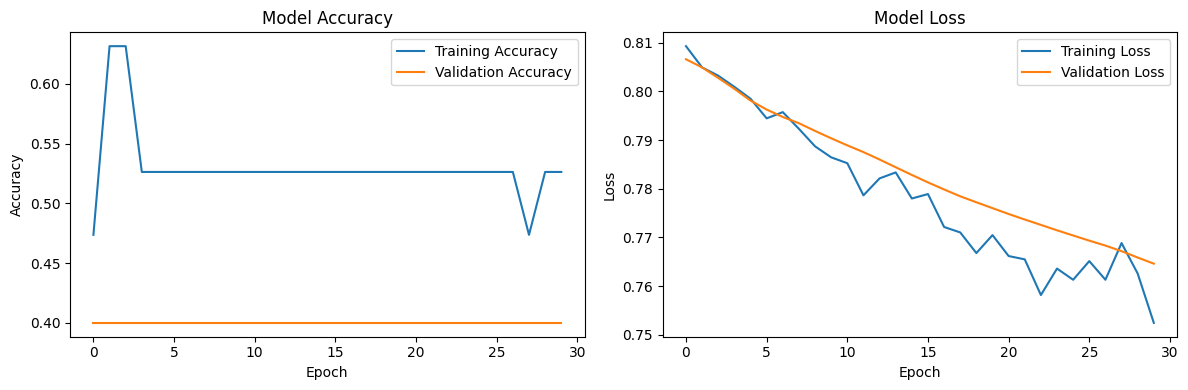

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Force eager execution to ensure layers build properly
tf.config.run_functions_eagerly(True)

# Calculate class weights (assuming binary classification)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Print shape information for debugging
print(f"Vocabulary size: {vocab_size}")
print(f"Maximum sequence length: {max_length}")
print(f"Training data shape: {X_train.shape}")

# Explicitly convert data to ensure correct format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Create improved model
model = Sequential([
    # Input layer with explicit shape
    tf.keras.layers.InputLayer(input_shape=(max_length,)),
    
    # Reduced embedding dimension
    Embedding(
        input_dim=vocab_size,
        output_dim=32,
        embeddings_regularizer=l2(0.0001)
    ),
    
    # Bidirectional LSTM with fewer units and regularization
    Bidirectional(LSTM(16, 
                       dropout=0.2, 
                       recurrent_dropout=0.2, 
                       kernel_regularizer=l2(0.001))),
    
    # Add an intermediate layer
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    
    # Reduced dropout
    Dropout(0.3),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile with adjusted learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Create callbacks for improved training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

# Print model summary
model.summary()

# Train the model with callbacks and class weights
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,  # Smaller batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Optional: Plot training history
try:
    import matplotlib.pyplot as plt
    
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not available for plotting history")

In [101]:
model.save('ques_gen.h5')

```json
[
  {
    "recipe_name": "Chocolate Chip Cookies",
    "ingredients": [
      "2 1/4 cups all-purpose flour",
      "1 teaspoon baking soda",
      "1 teaspoon salt",
      "1 cup (2 sticks) unsalted butter, softened",
      "3/4 cup granulated sugar",
      "3/4 cup packed brown sugar",
      "1 teaspoon vanilla extract",
      "2 large eggs",
      "2 cups chocolate chips"
    ]
  },
  {
    "recipe_name": "Peanut Butter Cookies",
    "ingredients": [
      "1 cup peanut butter",
      "1 cup granulated sugar",
      "1 cup packed brown sugar",
      "1 teaspoon vanilla extract",
      "2 large eggs",
      "1 teaspoon baking soda"
    ]
  },
  {
    "recipe_name": "Oatmeal Raisin Cookies",
    "ingredients": [
      "1 1/2 cups all-purpose flour",
      "1 teaspoon baking soda",
      "1 teaspoon ground cinnamon",
      "1/2 teaspoon salt",
      "1 cup (2 sticks) unsalted butter, softened",
      "3/4 cup packed brown sugar",
      "1/2 cup granulated sugar",
      "2 large

{"candidates":[{"content":{"parts":[{"video_metadata":null,"thought":null,"code_execution_result":null,"executable_code":null,"file_data":null,"function_call":null,"function_response":null,"inline_data":null,"text":"Okay, here's a set of 8-10 interview questions tailored to the provided job description and resume, aiming to assess John Doe's skills, experience, and fit for the role:\n\n**Technical Questions:**\n\n1.  **\"Tell me about a time you designed and implemented a scalable application using Python and AWS. What were the key architectural decisions you made, and what challenges did you encounter?\"** (Probes experience with Python, AWS, scalability, and problem-solving.)\n\n2.  **\"Describe a complex data processing project you worked on. What technologies did you use, and how did you optimize the processing pipeline for performance?\"** (Explores experience with large-scale data, performance optimization, and technology choices.)\n\n3.  **\"You mentioned experience with SQL dat

C:\Users\adity\AppData\Local\Temp\ipykernel_28508\1385795465.py:39: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_content = response.json()  # assuming the response is in JSON format
